# Comparing different methods of position reconstruction considering 1D readout of GEM detectors



In [26]:
import pandas as pd
import numpy as np
import math
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib import container
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.cm as cm

## Auxiliar functions
The class **one_significant_digit** is used to format a number in a string with one significant digit considering its uncertainty. The method format1() of this class was used in the legend of the graph "Electron cloud projected in x direction".

In [27]:
class one_significant_digit:
    def __init__(self,value,svalue):
        self.value=value
        self.svalue=svalue
    def uncertainty(self):
        s="%.2g"%(self.svalue)
        i=s.find('.')
        f=len(s)
        if i!=-1:
            n=f-i-1
            if n==1 and self.svalue <1: n=n+1
            decimals="%0."+str(n)+"f"
            final_svalue=decimals % (self.svalue)
        if i==-1:  
            if len(s)==1: 
                n=1
                decimals="%0."+str(n)+"f"
                final_svalue=decimals % (self.svalue)
            else:
                n=0
                decimals="%0."+str(n)+"f"
                final_svalue=decimals % (self.svalue)            
        return final_svalue,decimals,n
    def format1(self):
        final_svalue,decimals,n=self.uncertainty()
        return decimals%self.value+'#'+final_svalue
    def format2(self):
        final_svalue,decimals,n=self.uncertainty()
        return decimals%self.value+'('+"%1.0f"%(float(final_svalue)*10**n)+")"

example 
value = 0.0005677
svalue=0.00000798


In [28]:
value = 0.05677900899
svalue=0.000798900997
format1=one_significant_digit(value,svalue).format1()
format2=one_significant_digit(value,svalue).format2()
print("From the method format1 we get %s and from the method format2 we get %s"%(format1,format2))

From the method format1 we get 0.0568#0.0008 and from the method format2 we get 0.0568(8)


## Readout geometry

1. Chose the parameters for the width and pitch of the strips
2. Define where the strip centers are going to be generated
3. Define where the electron clouds are going to be generated


#### 1. Chose the parameters for the width and pitch of the strips


In [29]:
strip_width=0.2#(mm). 
pitch=100/256#(mm).

#### 2. Define where the strip centers are going to be generated

The first_strip_pos is the first position for the first strip. We can have strips in the region given by:  **first_strip_pos<= p < last_strip_pos**. 

The strip_centers list define the positions **p** of the strip centers.


In [30]:
first_strip_pos=-5#(mm)
last_strip_pos=5#(mm)
strip_centers=np.arange(first_strip_pos,last_strip_pos,pitch)

#### 3. Define where the electron clouds are going to be generated

The first_cloud_pos is the first position for the first electron cloud. We can have clouds in the region given by: **first_cloud_pos<= $\mu$ <last_cloud_pos**

The electron_cloud_centers list define the positions **$\mu$** of the cloud centers.


In [31]:
first_cloud_pos=-2*pitch#(mm)
last_cloud_pos=2*pitch#(mm)
electron_cloud_centers=np.arange(first_cloud_pos,last_cloud_pos,pitch/10)

## Clustering Algorithm

A clustering algorithm is used to identify the strips corresponding to charges that came from the electron cloud. The algorithm first looks for a strip whose signal is above a defined seed value, 0.08 AU in this work, to find a strip that definitely contains a signal.

Then, starting from this seed strip, the algorithm scans in both directions to construct a cluster. The scan stops when it finds a strip that collected less charge than the threshold, a negative charge in this case, which means just noise. So we are going to find the positions $n_{1}$ and $n_{2}$. Which $n_{1}$ represents the first strip of the cluster and $n_{2}$ the last one.

1. Chose the parameters for the clustering algorithm
2. Input: Parameters defined in item 1., list with the charge collected by each strip and strip centers.
3. Output: List with the charge collected by each strip and strip of the cluster

#### 1. Chose the parameters for the clustering algorithm

In [32]:
seed=0.08#(AU)
threshold=0#(AU)

In [33]:
class Cluster:
    def __init__(self,seed,threshold,Charges,Positions):
        self.seed=seed
        self.Q=Charges
        self.P=Positions
        self.zero=threshold
        
    def find_seed(self):
        i=0
        Qi=self.Q[i]
        while Qi<self.seed:
            i=i+1
            Qi=self.Q[i]
        seed_index=i
        return seed_index
    
    def scans_left(self,n1):
        Qleft=self.Q[n1]
        while Qleft>self.zero and n1!=0:
                n1=n1-1
                Qleft=self.Q[n1]      
        if Qleft>self.zero:
            return n1
        else:
            n1=n1+1 
            return n1
        
    def scans_right(self,n2): 
        Qright=self.Q[n2] 
        last_index=len(self.Q)-1
        while Qright>self.zero and n2<last_index:
            n2=n2+1
            Qright=self.Q[n2]
        if Qright>self.zero:
            return n2
        else: 
            n2=n2-1
            return n2
        
    def Find_Cluster(self):
        if (len([k for k in self.Q if k>self.seed])==0):
            raise NameError("All strips collected less charge than the seed value")
        seed_index=self.find_seed()
        n1=seed_index
        n2=seed_index
        last_index=len(self.Q)-1
        '''We considered three cases for the seed_index, the seed_index equals to: the index of the first strip,
        equals to the index of the last strip, and between them.'''
        if seed_index>0 and seed_index<last_index:
            n1=self.scans_left(seed_index-1)
            n2=self.scans_right(seed_index+1)
        elif seed_index==0:
            n1=0
            n2=self.scans_right(seed_index+1)
        elif seed_index==last_index:
            n2=last_index 
            n1=self.scans_left(n2) 
            
        if n1!=n2:
            n2=n2+1
            P_Cluster=self.P[n1:n2]
            Q_Cluster=self.Q[n1:n2]
        else:
            #when n1=n2, we create an array with a single element in it
            P_Cluster=np.zeros(1)
            Q_Cluster=np.zeros(1)
            P_Cluster[0]=self.P[n1]
            Q_Cluster[0]=self.Q[n1]    
        return Q_Cluster,P_Cluster

#### 2. Input: Parameters defined in item 1., list with the charge collected by each strip, and list with strip centers.


**Input Example:**


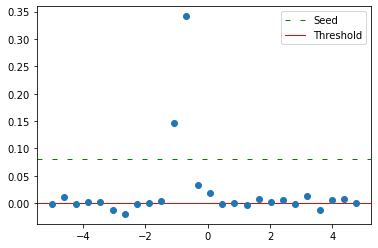

In [34]:
Positions=[-5.,-4.609375,-4.21875,-3.828125,-3.4375,-3.046875,-2.65625,-2.265625,-1.875,-1.484375,-1.09375,-0.703125,-0.3125,0.078125,0.46875,0.859375,1.25,1.640625,2.03125,2.421875,2.8125,3.203125,3.59375,3.984375,4.375,4.765625]
Charges=[-1.03914081e-03,1.09993525e-02,-7.29634817e-04,1.61512445e-03,3.03397209e-03,-1.28861052e-02,-1.95896215e-02,-1.01560310e-03,3.05840526e-04,4.84257401e-03,1.47319283e-01,3.41579687e-01,3.30470980e-02,1.79656041e-02,-7.49669035e-04,3.72049140e-04,-2.55898026e-03,6.84065913e-03,1.70936534e-03,6.48918403e-03,-6.32020983e-04,1.31020079e-02,-1.22746997e-02,5.54564277e-03,7.70664978e-03,8.10971044e-04]
fig, ax = plt.subplots()
plt.axhline(seed,label="Seed", linestyle=(0,(5,10)),color="green",linewidth=1.0)
plt.axhline(threshold,label="Threshold",color="red",linewidth=1.0)
ax.plot(Positions,Charges,"o")
plt.legend(loc="upper right")
plt.show()

#### 3. Output: List with the charge collected by each strip and strip of the cluster

**Output Example:**


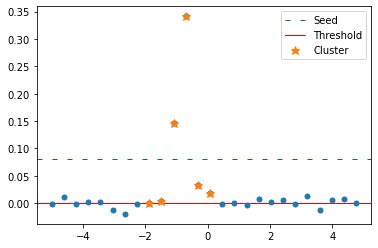

In [35]:
myCluster=Cluster(seed,threshold,Charges,Positions)
Q_Cluster,P_Cluster=myCluster.Find_Cluster()
fig, ax = plt.subplots()
plt.axhline(seed,label="Seed", linestyle=(0,(5,10)),color="green",linewidth=1.0)
plt.axhline(threshold,label="Threshold",color="red",linewidth=1.0)
ax.plot(Positions,Charges,"o",markersize=5)
ax.plot(P_Cluster,Q_Cluster,"*",markersize=9,label="Cluster")
plt.legend(loc="upper right")
plt.show()

## Charge collected by each strip 

The clas strips integrator has methods which give us the charge collected by each strip j with L width.

Input:
Cloud modeled as a gaussian normalized funtion

$$\begin{equation}
q_{j}=\int_{x_{j}-L / 2}^{x_{j}+L / 2} Gauss(x) d x
\end{equation}$$

Cloud modeled as a normal distribution (discrete data separeted in bins)

\begin{equation}
q_{j} =\sum _{L}q_{bin}Bin
\end{equation}

In [36]:
class Strips_Integrator:
    def __init__(self,strip_width,pitch,Position_strips):
        self.strip_width=strip_width
        self.pitch=pitch
        self.Position_strips=Position_strips
        
    def Normal(self,x,s,u):
        return (1/(s*np.sqrt(2*math.pi)))*math.exp( -((x-u)**2) / (2*s**2)  )
    
    def IntegraStrip(self,p,s,u):
        I = quad(self.Normal, p-self.strip_width/2, p+self.strip_width/2, args=(s,u))
        return I[0]

    def Charge_Strip(self,s,u):
        Charges_strips=[self.IntegraStrip(p,s,u) for p in self.Position_strips]
        return Charges_strips
    
    def IntegraBins_Strip(self,p,x_coordinate,charge_fraction):
        strip_begin=p-self.strip_width/2
        strip_end=p+self.strip_width/2
        last_index_x=len(x_coordinate)-1
    
        #strips out of the electron cloud range are going to be considered as zero charge strips
        if (strip_end)<x_coordinate[0]:
            return 0
        if (strip_begin)>x_coordinate[last_index_x]:
            return 0
        i=0
        I=0
        while i<(last_index_x) and x_coordinate[i] < (strip_end): 
            if x_coordinate[i]>(strip_begin) and x_coordinate[i]<(strip_end):
                I=I+charge_fraction[i]*(x_coordinate[i+1]-x_coordinate[i])  
            i=i+1
        return I
        
    def ChargeBins_Strip(self,x_coordinate,charge_fraction):
        Charges_strips=[self.IntegraBins_Strip(p,x_coordinate,charge_fraction) for p in self.Position_strips]
        return Charges_strips
 

### Methods for position reconstruction 
$$\begin{equation}
P_{lin}=\frac{\sum ^{n_2}_{j=n_1} {Q}_{j}x_j}{\sum ^{n_2}_{j=n_1} {Q}_{j}}
\end{equation}$$

$$\begin{equation}
P_{sq}=\frac{\sum ^{n_2}_{j=n_1}( {Q}_{j})^{2}x_j}{\sum ^{n_2}_{j=n_1}( {Q}_{j})^{2}}
\end{equation}$$

$$\begin{equation}
P_{log}=\frac{\sum ^{n_2}_{j=n_1}ln\left( {Q}_{j}+1\right)x_j}{\sum ^{n_2}_{j=n_1}ln\left( {Q}_{j}+1\right)}
\end{equation}$$


In [37]:
class Position_Reconstruction:
    def __init__(self,Charges,Positions):
        self.StripCharges=Charges
        self.StripPositions=Positions
        
    def linear(self):
        return sum(self.StripCharges*self.StripPositions)/sum(self.StripCharges)
    
    def quadratic(self):
        return sum((self.StripCharges**2)*self.StripPositions)/sum(self.StripCharges**2)
    
    def logarithmic(self):
        charges=[np.log(k+1) for k in self.StripCharges]
        return sum(charges*self.StripPositions)/sum(charges)

## Monte Carlo
#### Noise considered in Monte Carlo
Sigma is the standard deviation for a gaussian distribution. The noise affecting each strip is represented for a value drawn from these distribution.

\begin{equation}
Q_{j}=q_{j}+Random.Gauss(\sigma _{r})
\end{equation}

#### Total charge of a clusterized electron cloud

\begin{equation}
Q_{Total}\left( \mu \right) =\sum ^{n_{2}}_{j=n_{1}}Q_{j}
\end{equation}


#### Error of position reconstruction

The error is calculated for the three different methods of position reconstruction

$$\begin{equation}
Error(\mu)=P-\mu
\end{equation}$$


#### The Monte Carlo calculates N events for charge reconstrucion and errors of the position reconstruction, then it returns:

#### output

* Mean values:
\begin{equation}
\overline{Q_{Total}}\left( \mu \right) =\frac{1}{N}\sum ^{N}_{i}(Q_{Total})_i\left( \mu \right)
\end{equation}

For the three methods of position reconstruction considered:
\begin{equation}
\overline{Error}(\mu)=\frac{1}{N}\sum ^{N}_{i}Error_{i}(\mu)
\end{equation}

* Standard deviation of the mean values:

$$\overline{\sigma}_\overline{Q_{Total}} = \sqrt{\frac{1}{N-1} \sum_{i=1}^N ((Q_{Total})_i - \overline{Q_{Total}})^2}$$

For the three methods of position reconstruction considered:


$$\overline{\sigma}_{\overline{Error}} = \sqrt{\frac{1}{N-1} \sum_{i=1}^N (Error_i - \overline{ Error})^2}$$



In [38]:
snoise=0.01
N=1000

In [39]:
def Monte_Carlo(sig_noise,N,u,Charge_strip,Position_strip,seed,threshold):
    Data=[]                           
    for i in range(N):
        Noise=np.random.normal(0,sig_noise,len(Charge_strip))
        Charge_strip_noise=Charge_strip+Noise
        Charge_Cluster,Position_Cluster=Cluster(seed,threshold,Charge_strip_noise,Position_strip).Find_Cluster()
        Data.append([sum(Charge_Cluster),Position_Reconstruction(Charge_Cluster,Position_Cluster).linear()-u,Position_Reconstruction(Charge_Cluster,Position_Cluster).quadratic()-u,Position_Reconstruction(Charge_Cluster,Position_Cluster).logarithmic()-u])  
    df=pd.DataFrame(Data, columns=["Q","E_linear","E_quadratic","E_logarithmic"])
    
    Charge_mean=np.mean(df['Q'])
    E_linear=np.mean(df['E_linear'])
    E_quadratic=np.mean(df['E_quadratic'])
    E_logarithmic=np.mean(df['E_logarithmic'])
    
    sCharge=np.std(df['Q'],ddof=1)/np.sqrt(N)
    sE_linear=np.std(df['E_linear'],ddof=1)/np.sqrt(N)
    sE_quadratic=np.std(df['E_quadratic'],ddof=1)/np.sqrt(N)   
    sE_logarithmic=np.std(df['E_logarithmic'],ddof=1)/np.sqrt(N)
    
    return Charge_mean,sCharge,E_linear,sE_linear,E_quadratic,sE_quadratic,E_logarithmic,sE_logarithmic  

## Models for the electron cloud

### Analytical Model


The electron cloud was modeled as an gaussian distribution normalized, as shown by the following equation:

 $$Gauss(x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{ {- \left( {x - \mu } \right)^2}/{2\sigma ^2} }$$
 
Now we are just organazing the data in a DataFrame. We are calculating the data for the colected charge and 
the Errors whith linear, quadratic and logarithmic weights, considering different sigmas for the gaussian that 
stands for the electron cloud


In [40]:
#list of standard deviations for the electron clouds modeled as gaussians
slist=[0.2,0.25,0.3,0.35,0.4]


In [41]:
def Dataframe(strip_width,pitch,slist,snoise,N,Position_strips,electron_cloud_centers,seed,threshold):
    Data=[]
    for s in slist:
        for u in electron_cloud_centers:
            Charge_strips=Strips_Integrator(strip_width,pitch,Position_strips).Charge_Strip(s,u)
            Charge,sCharge,E_linear,sE_linear,E_quadratic,sE_quadratic,E_logarithmic,sE_logarithmic=Monte_Carlo(snoise,N,u,Charge_strips,Position_strips,seed,threshold)
            Data.append([s,u,Charge,sCharge,E_linear,sE_linear,E_quadratic,sE_quadratic,E_logarithmic,sE_logarithmic])
    df = pd.DataFrame(Data, columns=["s","u","Q","sQ","E_linear","sE_linear","E_quadratic","sE_quadratic","E_logarithmic","sE_logarithmic"])
    return df

In [42]:
df=Dataframe(strip_width,pitch,slist,snoise,N,strip_centers,electron_cloud_centers,seed,threshold)
df.head()

,s,u,Q,sQ,E_linear,sE_linear,E_quadratic,sE_quadratic,E_logarithmic,sE_logarithmic
0,0.2,-0.781250,0.528523,0.000820,0.007123,0.001527,0.038518,0.000233,0.003708,0.001691
1,0.2,-0.742188,0.531947,0.000832,0.005461,0.001856,0.022664,0.000184,0.003441,0.002064
2,0.2,-0.703125,0.530738,0.000765,0.004395,0.001743,0.000221,0.000171,0.004914,0.001942
3,0.2,-0.664062,0.531847,0.000806,-0.003385,0.001608,-0.022144,0.000178,-0.001201,0.001791
4,0.2,-0.625000,0.528733,0.000778,-0.005471,0.001547,-0.038715,0.000220,-0.001822,0.001716


In [43]:
def Plot_Charge_or_Error(Name,slist, df, markers, markersizes,ymin,ymax,Title,Ylabel):
    for s in slist:
        t=r'$\sigma $ '+' '+str(s)+"mm"
        plt.errorbar(df.loc[df['s'].isin([s]),'u'], df.loc[df['s'].isin([s]),Name], marker=markers[slist.index(s)],markersize=markersizes[slist.index(s)], linestyle='' ,label=t,xerr=0, yerr=df.loc[df['s'].isin([s]),'sE_linear'])
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
    ax.legend(handles, labels,loc='upper right')
    plt.title(Title)
    plt.ylabel(Ylabel) 
    plt.ylim(ymin,ymax)
    plt.xlabel(r'$\mu$ (mm)')
    plt.grid(True)
    plt.show()

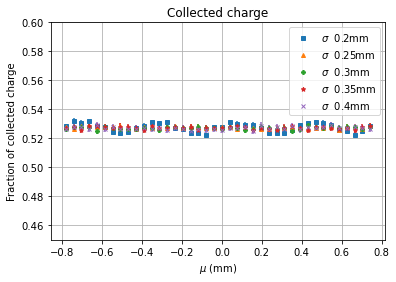

In [44]:
markers=['s','^','P','*','x']
markersizes=[4,4,4,14/3,4]
ymax=0.6
ymin=0.45

Title={"Q":"Collected charge"}
Title_pt={"Q":'Carga coletada pelas fitas'}
Ylabel={"Q":'Fraction of collected charge'}
Ylabel_pt={"Q":'Fração de carga coletada'}
Plot_Charge_or_Error('Q',slist, df, markers, markersizes,ymin,ymax,Title["Q"],Ylabel['Q'])

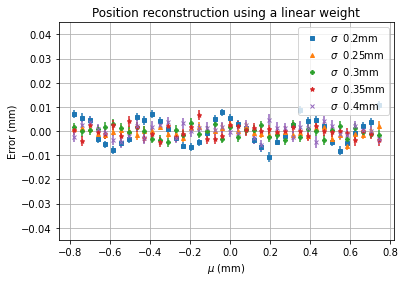

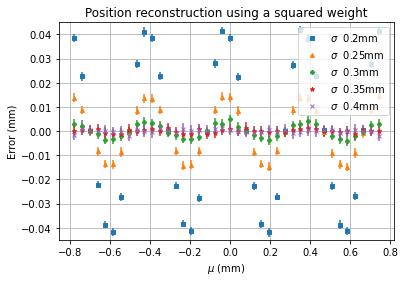

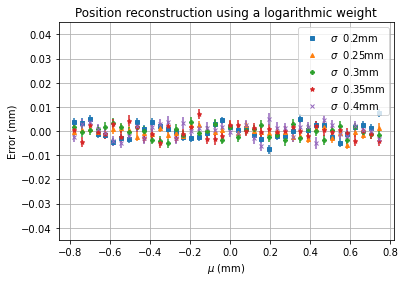

In [45]:
ymin=-0.045
ymax=0.045

Title={"E_linear":"Position reconstruction using a linear weight",
       "E_quadratic":"Position reconstruction using a squared weight",
       "E_logarithmic": "Position reconstruction using a logarithmic weight"}
Ylabel={"E":'Error (mm)'}

Title_pt={ "E_linear":"Reconstrução da posição usando peso linear",
          "E_quadratic":"Reconstrução da posição usando peso quadrático",
          "E_logarithmic": "Reconstrução da posição usando peso logaritmico"}
Ylabel_pt={"E":'Erro (mm)'}

Plot_Charge_or_Error("E_linear",slist, df, markers, markersizes,ymin,ymax,Title["E_linear"],Ylabel['E'])
Plot_Charge_or_Error("E_quadratic",slist, df, markers, markersizes,ymin,ymax,Title["E_quadratic"],Ylabel['E'])
Plot_Charge_or_Error("E_logarithmic",slist, df, markers, markersizes,ymin,ymax,Title["E_logarithmic"],Ylabel['E'])

## Comparing the three methods for position reconstruction

\begin{equation}
RMS=\sqrt{\frac{1}{M} \sum_{k}^{M} \overline{Error} \left(\mu_k\right)^{2}}
\end{equation} 

In [46]:
def RMS(v):
    return np.sqrt((v*v).sum()/len(v))

def RMS_Dataframe(slist,df):
    Data=[]
    for s in slist:
        Data.append([s,
                     RMS(df.loc[df['s'].isin([s]),'E_linear']), 
                     RMS(df.loc[df['s'].isin([s]),'E_quadratic']), 
                     RMS(df.loc[df['s'].isin([s]),'E_logarithmic'])])
    RMS_df = pd.DataFrame(Data,columns=['s','E_linear','E_quadratic','E_logarithmic'])
    return RMS_df

def Plot_RMS(RMS_df,Labels):
    plt.title(Labels["Title"]) 
    plt.plot(RMS_df['s'],RMS_df['E_linear'],marker=markers[0], markersize=markersizes[0]*1.5,linestyle='' ,label="Linear weight")
    plt.plot(RMS_df['s'],RMS_df['E_quadratic'],marker=markers[1],  markersize=markersizes[1]*1.5, linestyle='' ,label="Squared weight")
    plt.plot(RMS_df['s'],RMS_df['E_logarithmic'],marker=markers[2],  markersize=markersizes[2]*1.5,linestyle='' ,label="Logarithmic weight")
    plt.ylabel(Labels["ylabel"]) 
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
    ax.legend(handles, labels,loc='upper right')
    plt.xlabel(r'$\sigma$ (mm)')  
    plt.grid(True)
    plt.show()

In [47]:
RMS_df=RMS_Dataframe(slist,df)
RMS_df.head()

,s,E_linear,E_quadratic,E_logarithmic
0,0.20,0.005380,0.029926,0.003156
1,0.25,0.001751,0.010391,0.001691
2,0.30,0.002152,0.002624,0.002326
3,0.35,0.002358,0.000702,0.002505
4,0.40,0.002617,0.000745,0.002752


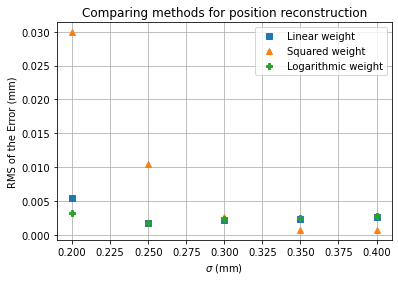

In [48]:
Labels={"Title":"Comparing methods for position reconstruction",
        "ylabel":'RMS of the Error (mm)'}
Labels_pt={"Title":"Comparing methods for position reconstruction",
           "ylabel":'Erro do RMS (mm)'}
Plot_RMS(RMS_df,Labels)

## Discrete electron cloud

No we are no longer model the electron cloud as a gaussian funtion, but a simulated data by the software Garfield++, as shown in the 2D histogram "Electron cloud after multiplication 8 keV Photon $Ar/CO_2$ (70/30)".


### DATA

Creating a Dataframe with the input data

In [49]:
file="evt1.txt"
electron_cloud_df=pd.read_csv(file,sep='\s+',header=None)
electron_cloud_df.rename({0: 'x', 1: 'y',2:'E'}, axis=1, inplace=True)
electron_cloud_df[['x','y']]=electron_cloud_df[['x','y']]/1000
electron_cloud_df.head()

,x,y,E
0,-1.024156,-1.187231,0.0
1,-1.024156,-1.185177,0.0
2,-1.024156,-1.183124,0.0
3,-1.024156,-1.181071,0.0
4,-1.024156,-1.179017,0.0


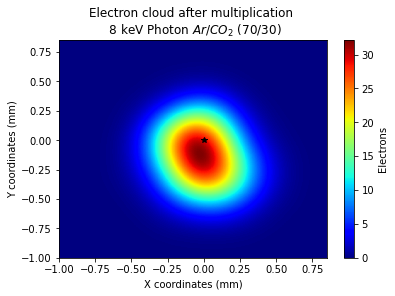

In [50]:
def Plot_Hist2d(x,y,z,nbins,Labels):
    fig, ax = plt.subplots()
    counts, xedges, yedges, im = ax.hist2d(x, y,bins=nbins,weights=z,cmap=cm.jet)
    fig.colorbar(im, ax=ax,label=Labels["colorbar"])
    ax.set_ylim(-1,0.85)
    ax.set_xlim(-1,0.85)
    ax.set_xlabel(Labels["xlabel"])
    ax.set_ylabel(Labels["ylabel"])
    plt.title(Labels["Title"])
    plt.plot(0,0,"*",color="black")
    plt.show()
    
Labels={"Title": "Electron cloud after multiplication \n 8 keV Photon "+r"$Ar/CO_2$ (70/30)",
        "xlabel": "X coordinates (mm)",
        "ylabel": "Y coordinates (mm)",
        "colorbar": "Electrons"}
Labels_pt={"Title": "Nuvem de elétrons depois da multiplicação \n Fóton de 8 KeV "+r"$Ar/CO_2$ (70/30)",
        "xlabel": 'Coordeadas em x (mm)',
        "ylabel": 'Coordenadas em y (mm)',
        "colorbar": "Elétrons"}
Plot_Hist2d(electron_cloud_df['x'], electron_cloud_df['y'], electron_cloud_df['E'], 1000,Labels)

### Projection of the electron cloud in x direction

Since we have a monodimensional readout of strips, is cponvinient to make a projection of the data in x direction and than, use the same algorithms used for the analytical cloud analyses. To reduce the bins effect on the integration of the charge, we are going to interpolate de data.

[]

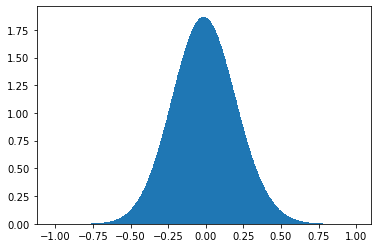

In [51]:
def x_projection(df):
    xprojection=df.groupby('x')['E'].sum().reset_index()
    Bin=xprojection.iat[1,0]-xprojection.iat[0,0]
    xprojection['E']=xprojection['E']/(xprojection['E']*Bin).sum()    
    return xprojection['x'],xprojection['E']
x_coordinate,charge_fraction=x_projection(electron_cloud_df)

plt.hist(x_coordinate,weights=charge_fraction,bins=1000)
plt.plot()

In [52]:
def interpolation(x_coordinate,charge_density):
    f=interp1d(x_coordinate, charge_density,kind='cubic')
    n=50
    x=np.linspace(x_coordinate[0],x_coordinate[len(x_coordinate)-1],num=n*len(x_coordinate),endpoint=True)
    E=f(x)
    return x,E
x_coordinate_interpolate,charge_fraction_interpolate=interpolation(x_coordinate,charge_fraction)

In [53]:
def Func_Normal(x, x0, sigma):
    return (1/(sigma*np.sqrt(2*math.pi))) * np.exp(-(x - x0)**2 / (2.0 * sigma**2))

In [54]:
mean = sum(x_coordinate * charge_fraction) / sum(charge_fraction)
sigma = np.sqrt(sum(charge_fraction * (x_coordinate - mean)**2) / sum(charge_fraction))
popt,pcov = curve_fit(Func_Normal, x_coordinate, charge_fraction, p0=[mean, sigma])
s=popt[1]# popt[1] is the fit result for sigma 

In [55]:
def Plot_xProjection_fit(x_coordinate,charge_fraction,Position_strips,popt,pcov,Labels):
    inc=np.sqrt(np.diagonal(pcov))   
    fig = plt.figure()
    gs = fig.add_gridspec(2, hspace=0,height_ratios=[2,1])
    axs = gs.subplots(sharex=True)
    title=Labels["Title"]
    fig.suptitle(title)
    axs[0].hist(x_coordinate, weights=charge_fraction,bins=len(x_coordinate))
    axs[0].plot(x_coordinate, Func_Normal(x_coordinate, *popt), 'r-',label='fit:'+r' $\mu$='+one_significant_digit(popt[0],inc[0]).format2()+"mm, "+r'$\sigma$='+one_significant_digit(popt[1],inc[1]).format2()+"mm")
    axs[0].set_ylabel(Labels['0_ylabel'])
    axs[0].set_ylim(0,3)
    axs[0].legend(loc='upper right')
    axs[0].xaxis.set_major_locator(MultipleLocator(0.4))
    axs[0].xaxis.set_minor_locator(MultipleLocator(0.2))
    Residuals=charge_fraction-Func_Normal(x_coordinate,*popt)
    axs[1].plot(x_coordinate,Residuals,linestyle="None",marker="*",markersize=1,color='b')
    axs[1].set_xlabel(Labels['xlabel'])
    axs[1].set_ylabel(Labels['1_ylabel'])
    axs[1].set_xlim(-1.2,1.2)
    axs[1].grid(axis="y") 
    rectangles=[k for k in Position_strips if k >-1.2 and k<1.2]
    trans0 = transforms.blended_transform_factory(axs[0].transData, axs[0].transAxes)
    trans1 = transforms.blended_transform_factory(axs[1].transData, axs[1].transAxes)
    for i in rectangles:
        rect0 = mpatches.Rectangle((i, 0), width=0.2, height=1, transform=trans0,color='red', alpha=0.5)
        rect1 = mpatches.Rectangle((i, 0), width=0.2, height=1, transform=trans1,color='red', alpha=0.5)
        axs[0].add_patch(rect0)
        axs[1].add_patch(rect1)
    plt.show()

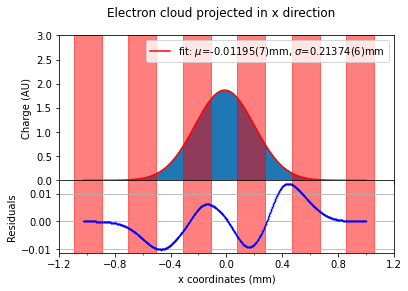

In [56]:
Labels={"Title": "Electron cloud projected in x direction",
        "xlabel": "x coordinates (mm)",
        "0_ylabel": "Charge (AU)",
         "1_ylabel": "Residuals"}

Labels_pt={"Title": "Projeção da nuvem de elétrons na direção x",
            "xlabel": "Coordenadas em x (mm)",
            "0_ylabel": "Carga (UA)",
            "1_ylabel": "Resíduos"}
Plot_xProjection_fit(x_coordinate, charge_fraction,strip_centers,popt,pcov,Labels)

In [57]:
def G_Dataframe(strip_width,pitch,s,snoise,N,Position_strips,x_coordinate,charge_fraction,electron_cloud_centers,seed,threshold):
    Data=[]
    for u in electron_cloud_centers:
        x_new_coordinate=x_coordinate+u
        Charge_strips=Strips_Integrator(strip_width,pitch,Position_strips).ChargeBins_Strip(x_new_coordinate,charge_fraction)
        Charge,sCharge,E_linear,sE_linear,E_quadratic,sE_quadratic,E_logarithmic,sE_logarithmic=Monte_Carlo(snoise,N,u,Charge_strips,Position_strips,seed,threshold)
        Data.append([s,u,Charge,sCharge,E_linear,sE_linear,E_quadratic,sE_quadratic,E_logarithmic,sE_logarithmic])
    df = pd.DataFrame(Data, columns=["s","u","Q","sQ","E_linear","sE_linear","E_quadratic","sE_quadratic","E_logarithmic","sE_logarithmic"])
    return df

In [58]:
df=G_Dataframe(strip_width,pitch,s,snoise,N,strip_centers,x_coordinate_interpolate,charge_fraction_interpolate,electron_cloud_centers,seed,threshold)
df.head()

,s,u,Q,sQ,E_linear,sE_linear,E_quadratic,sE_quadratic,E_logarithmic,sE_logarithmic
0,0.213745,-0.781250,0.526905,0.000816,-0.003197,0.001828,0.021116,0.000289,-0.005526,0.002003
1,0.213745,-0.742188,0.528590,0.000774,-0.003158,0.001555,0.012443,0.000229,-0.004721,0.001714
2,0.213745,-0.703125,0.529944,0.000810,-0.006724,0.001755,-0.004723,0.000213,-0.006908,0.001939
3,0.213745,-0.664062,0.528756,0.000756,-0.011477,0.001526,-0.023519,0.000211,-0.010204,0.001686
4,0.213745,-0.625000,0.526961,0.000788,-0.013519,0.001689,-0.039129,0.000250,-0.010928,0.001857


In [59]:
def Plot_Errors(df,label):
    plt.errorbar(df['u'],df['E_linear'],marker='o',markersize=3, linestyle='',label=label['E_linear'],xerr=0, yerr=df['sE_linear'])
    plt.errorbar(df['u'],df['E_quadratic'],marker='o',markersize=3, linestyle='',label=label['E_quadratic'],xerr=0, yerr=df['sE_quadratic'])
    plt.errorbar(df['u'],df['E_logarithmic'],marker='o',markersize=3, linestyle='',label=label['E_logarithmic'],xerr=0, yerr=df['sE_logarithmic'])
    plt.title(label['Title'])
    plt.legend(loc='upper right')
    plt.ylabel(label['ylabel'])
    plt.xlabel(r'$\mu$ (mm)')
    plt.grid()
    plt.show()

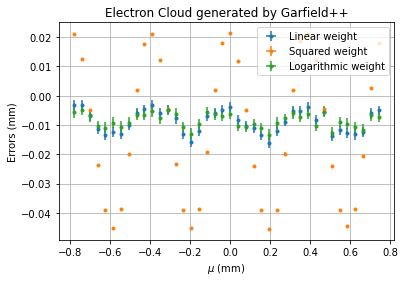

In [60]:
labels={'E_linear':'Linear weight',
       'E_quadratic':'Squared weight',
       'E_logarithmic':'Logarithmic weight',
       'Title': 'Electron Cloud generated by Garfield++',
       'ylabel': 'Errors (mm)'
       }
   
labels_pt={'E_linear':'Peso linear',
       'E_quadratic':'Peso quadrático',
       'E_logarithmic':'Peso logarítmico',
       'Title':'Nuvem de elétrons geradas pelo Garfield++',
       'ylabel':'Erros (mm)'
       }

Plot_Errors(df,labels)